<a href="https://colab.research.google.com/github/dar10p/atmos-optics/blob/FGbranch/Tarea_1_Imaging_Simulator_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 1.** Simulador de imagen por un sistema óptico.
## Felipe Guzmán

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se importan las librerías necesarias:

*   numpy para cálculos
*   matplotlib para herramientas de gráficos



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from matplotlib.pyplot import figure

valor máximo Se genera el objeto $I_g(u,v)$ que corresponde a la irradiancia geometrica perfecta definida en el capítulo 7 del Voelz [Computational Fourier Optics: A MATLAB tutorial](https://drive.google.com/file/d/1URAoRYjupz7E_ei5rFyL-uzsaPJHpiK9/view). Este corresponde a una imagen natural normalizada por su intensidad maxima. Para este ejemplo se utilizó la placa de calibración `USAF 1951` con un tamaño de pixel de $2048 \times 2048$.




In [ ]:
size= 2048
im = plt.imread('/content/drive/My Drive/Colab Notebooks/usaf.jpg') #Mount your drive and RUN
im = rgb2gray(im) # if  len(im) != size then
im = resize(im,[size,size])
Ig = im - np.amin(im) # remove minimum
Ig = Ig/np.amax(Ig) # normalize by the maximum.

[M,N] = im.shape

Se definen los siguientes parametros:
*   $L$ es el tamaño del plano de imagen
*   $\Delta u$ corresponde al intervalo de sampleo
*   $(u,v)$ corresponden a los ejes coordenados del plano imagen en $\text{m}$







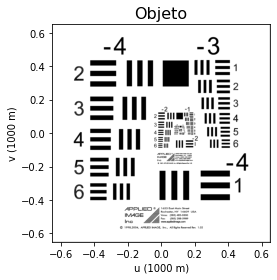

In [ ]:
L = 1.3*10**-3 #Side length
du = L/M
u = np.linspace(-(L/2),(L/2),size)
v = u

plt.imshow(Ig,'gray',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
plt.title('Objeto', fontsize=16)
plt.xlabel('u (1000 m)') # meters
plt.ylabel('v (1000 m)')
plt.show()


Para modelar un sistema óptico, se considera la longitud de onda $\lambda$, la distancia a la pupila de entrada $z_\text{ep}$, diámetro de la pupila de entrada $D_{ep}$, diámetro de la pupila de salida y el numero f del lente $f/\text{#}$

Considerando un sistema de lente plano, $z_1=z_\text{ep}$ y $z_2=z_\text{xp}$ donde $(z_1,z_2$ son las distancias de la imagen al lente y lente al plano imagen respectivamente, además $D_\text{ep} = D_\text{xp} = D_l$ donde $D_l$ corresponde al diámetro del lente lo cual es muy conveniente para el diseño ya que se tiene la siguiente expresión $$f/\text{#} = \frac{z_\text{xp}}{D_\text{xp}}. $$

Para un sistema de imagen incoherente, la frecuencia de corte determinada por el lente está determinado por $$ f_0 = \frac{w_\text{xp}}{\lambda z_\text{xp}}.$$






In [ ]:
lamb = 0.5*10**-6
f_number = 4
zxp = 125*10**-3
Dxp = zxp/f_number
wxp = Dxp/2
f0 = wxp/(lamb*zxp)
k=2*np.pi/lamb

Con la funcion $\text{circ}\!\left(\frac{\rho}{f_0}\right)$ se puede generar una mascara circular de radio $f_0$

In [ ]:
def circ(R): # index function for the pupil entrance
  out = abs(R)<=1
  return out


Se genera los vectores de coordenadas frecuenciales $(f_U,f_V)$

In [ ]:
fu = np.linspace(-(1/(2*du)),(1/(2*du)),size) #frequency vectors
fv = fu
Fu, Fv = np.meshgrid(fu,fv,sparse=True)
H = circ(np.sqrt(Fu**2+Fv**2)/f0) #pupil


En esta parte se genera la mascara $h(f_U,f_V)$ y con la función $\text{H_to_OTF}$ se realiza la simulacion de la funcion de transferencia óptica 

$$\mathcal{H}\left(f_{U}, f_{V}\right)=\frac{\mathcal{F}\left\{\left|h(u, v)\right|^{2}\right\}}{\iint_{\mathbb{R}^2}|h(u, v)|^{2} d u d v}.$$

La normalización de $\mathcal{H}$ se realiza con su aporte de frecuencia 0 con el objetivo de tener un factor de escala de 1 en dicha frecuencia.

In [ ]:
def H_to_OTF(H):
  OTF = np.fft.ifft2(abs(np.fft.fft2(np.fft.fftshift(H)))**2)
  OTF = OTF/OTF[0,0]
  return OTF

Como se observan en las figuras, la pupila simulada para un sistema incoherente tiene una forma cónica, mientras que en un sistema coherente es un cilindro, es decir el límite entre las regiones es gradual.

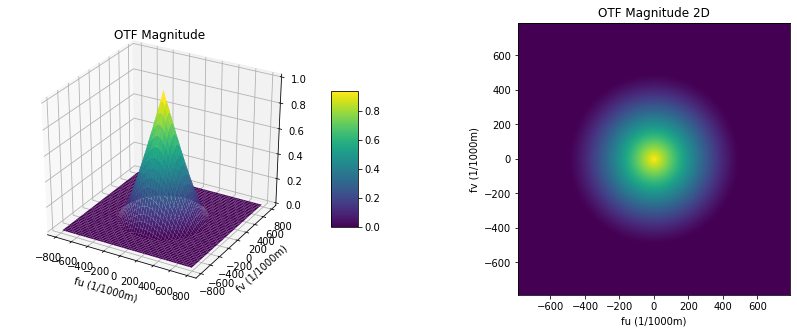

In [ ]:
OTF = H_to_OTF(H)

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')

surf = ax1.plot_surface(Fu/1000, Fv/1000, abs(np.fft.fftshift(OTF)),cmap='viridis', edgecolor='none',linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax1.set_title('OTF Magnitude')
ax1.set_xlabel('fu (1/1000m)')
ax1.set_ylabel('fv (1/1000m)')

ax2 = fig.add_subplot(1,2,2)
plt.imshow(abs(np.fft.fftshift(OTF)),extent = [-(1/(2*du))/1000 , (1/(2*du))/1000, -(1/(2*du))/1000, (1/(2*du))/1000]) # transfer function
ax2.set_title('OTF Magnitude 2D')
ax2.set_xlabel('fu (1/1000m)')
ax2.set_ylabel('fv (1/1000m)')
plt.show()


Para obtener la imagen generada en el plano, responde a la siguiente ecuación:
 $$I_{i}(u, v)=\mathcal{F}^{-1}\left\{\mathcal{H}\left(f_{U}, f_{V}\right) \mathcal{F}\left\{I_{g}(u, v)\right\}\right\}$$
donde $\mathcal{F}$ representa la transformada de Fourier, que incluyen el factor $2\pi$, entonces los resultados se expre

In [ ]:
Gg = np.fft.fft2(np.fft.fftshift(Ig))
Gi = Gg*OTF
Ii = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.real(Ii)
Ii = Ii*(Ii>=0)

Ya que, al ser un sistema digital, la transformada de Fourier es una aproximación lo que provoca que, para objetos de magnitud pura, al simular la formación de imagen, esta tenga residuos de fase por lo que, si se sabe que la fuente es de magnitud, se se utilizan las ultimas dos lineas para eliminar los residuos complejos de la imagen y los elementos negativos.

Text(0, 0.5, 'y 1000m')

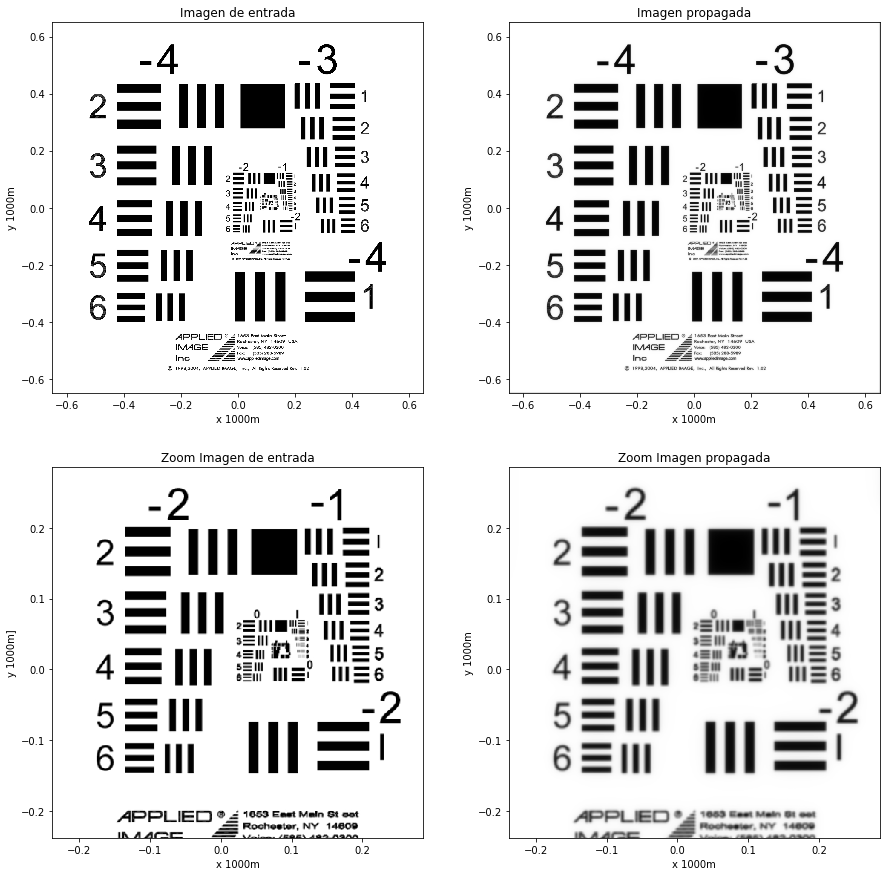

In [ ]:
fig1 = plt.figure(figsize = (15,15)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(Ig,'gray' ,interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen de entrada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')

ax1 = fig1.add_subplot(2,2,2) 
ax1.imshow(Ii,'gray' , interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen propagada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')


ax1 = fig1.add_subplot(2,2,3) 
ax1.imshow(Ig[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen de entrada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m]')


ax1 = fig1.add_subplot(2,2,4) 
ax1.imshow(Ii[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen propagada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')

En las imagenes se obtiene una comparación de la resolución conseguida por el sistema de imagen, con un zoom en los elementos mas pequeños del target de calibración.

## Aberraciones

Las aberraciones se pueden describir como un vector $\textbf{W}(x,y)$ el cual contiene las diferencias del frente de onda medido con respecto a un frente de onda ideal. 

Una buena herramienta para simular un frende de onda deformado, es utilizar los parametros de Seidel o Zernike, Seidel es un método clásico orientado a imperfecciones en sistemas ópticos como lentes, por otra parte, los polinomios de Zernike se pueden utilizar para cualquier tipo de aberraciones con la ventaja de que sus polinomios son ortogonales entre sí. 

Para este ejemplo se utilizaran deformaciones a traves de los coeficientes de Seidel dados por 

\begin{equation}
W\left(\hat{u}_{0} ; \rho, \theta\right)=\sum_{j, m, n} W_{k l m} \hat{\textbf{u}}_{0}^{k} \rho^{l} \cos ^{m} \theta ; \quad k=2 j+m, l=2 n+m
\end{equation}

donde $\theta$ es el angulo relativo al eje $x$, $\hat{\textbf{u}}_{0} = (\hat{u}_{0},\hat{v}_{0})$ determina las dimensiones de la imagen normalizada en los ejes $(u_0,v_0)$

In [ ]:
lz= zxp*lamb
u0=1
v0=1

Dependiendo de los volares de $k, \ l, \ m$, se definen distintos tipos de aberraciones clasicas que se pueden ver en la tabla 8.1 en el capítulo 8 del Voelz.

In [ ]:
wd=0*lamb      # defocus
w040=0*lamb    # spherical
w131=1.9*lamb  # coma 
w222=0*lamb    # astigmatisms
w220=0*lamb    # field curvature
w311=0*lamb    # distortion

In [ ]:
def seidel(u0,v0,X,Y,wd,w040,w131,w222,w220,w311):
  beta=math.atan2(v0,u0)   # image rotation angle
  u0r=np.sqrt(u0**2+v0**2) # image height
  Xr=X*np.cos(beta)+Y*np.sin(beta) #rotate grid
  Yr=-X*np.sin(beta)+Y*np.cos(beta)
  rho2=Xr**2+Yr**2
  W = wd*rho2+w040*rho2**2 + w131*u0r*rho2*Xr + w222*u0r**2*Xr**2 + w220*u0r**2*rho2+w311*u0r**3*Xr
  return W

Con las aberraciones $\textbf{W}(x,y)$  calculadas, estas modifican la funcion de transferencia $h(f_U,f_V)$ simulada anteriormente como

\begin{equation}
H_{ap} = H_{ip}e^{-jk\textbf{W}}
\end{equation}

In [ ]:
W=seidel(u0,v0,-lz*Fu/wxp,-lz*Fv/wxp,wd,w040,w131,w222,w220,w311)
H=circ(np.sqrt(Fu**2+Fv**2)/f0)*np.exp(-1j*k*W);
OTF = H_to_OTF(H)

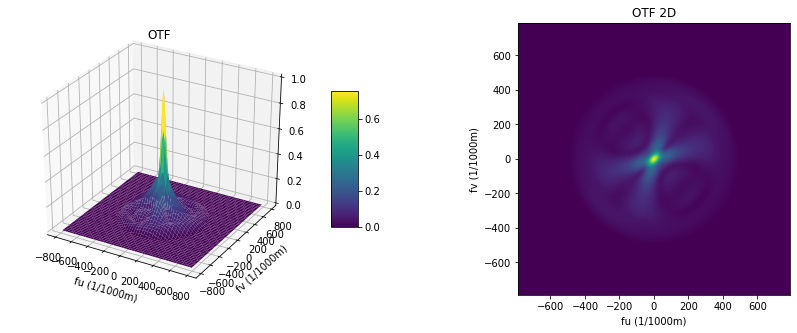

In [ ]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')

surf = ax1.plot_surface(Fu/1000, Fv/1000, abs(np.fft.fftshift(OTF2)),cmap='viridis', edgecolor='none',linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax1.set_title('OTF')
ax1.set_xlabel('fu (1/1000m)')
ax1.set_ylabel('fv (1/1000m)')

ax2 = fig.add_subplot(1,2,2)
plt.imshow(abs(np.fft.fftshift(OTF)),extent = [-(1/(2*du))/1000 , (1/(2*du))/1000, -(1/(2*du))/1000, (1/(2*du))/1000]) # transfer function
ax2.set_title('OTF 2D')
ax2.set_xlabel('fu (1/1000m)')
ax2.set_ylabel('fv (1/1000m)')
plt.show()

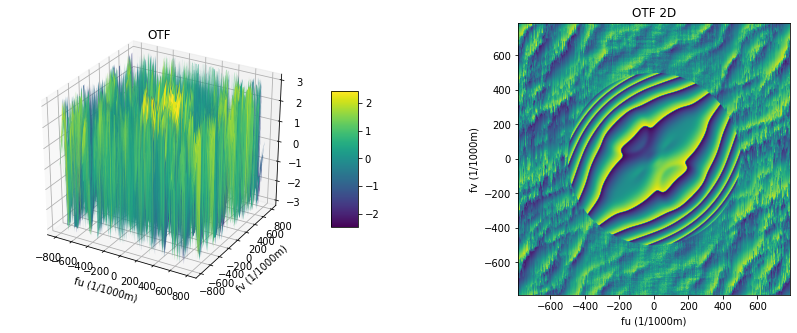

In [ ]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')

surf = ax1.plot_surface(Fu/1000, Fv/1000, np.angle(np.fft.fftshift(OTF)),cmap='viridis', edgecolor='none',linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax1.set_title('OTF')
ax1.set_xlabel('fu (1/1000m)')
ax1.set_ylabel('fv (1/1000m)')

ax2 = fig.add_subplot(1,2,2)
plt.imshow(np.angle(np.fft.fftshift(OTF)),extent = [-(1/(2*du))/1000 , (1/(2*du))/1000, -(1/(2*du))/1000, (1/(2*du))/1000]) # transfer function
ax2.set_title('OTF 2D')
ax2.set_xlabel('fu (1/1000m)')
ax2.set_ylabel('fv (1/1000m)')
plt.show()

In [ ]:
Gg = np.fft.fft2(np.fft.fftshift(Ig))
Gi = Gg*OTF
Ii = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.real(Ii)
Ii = Ii*(Ii>=0)

Text(0, 0.5, 'y 1000m')

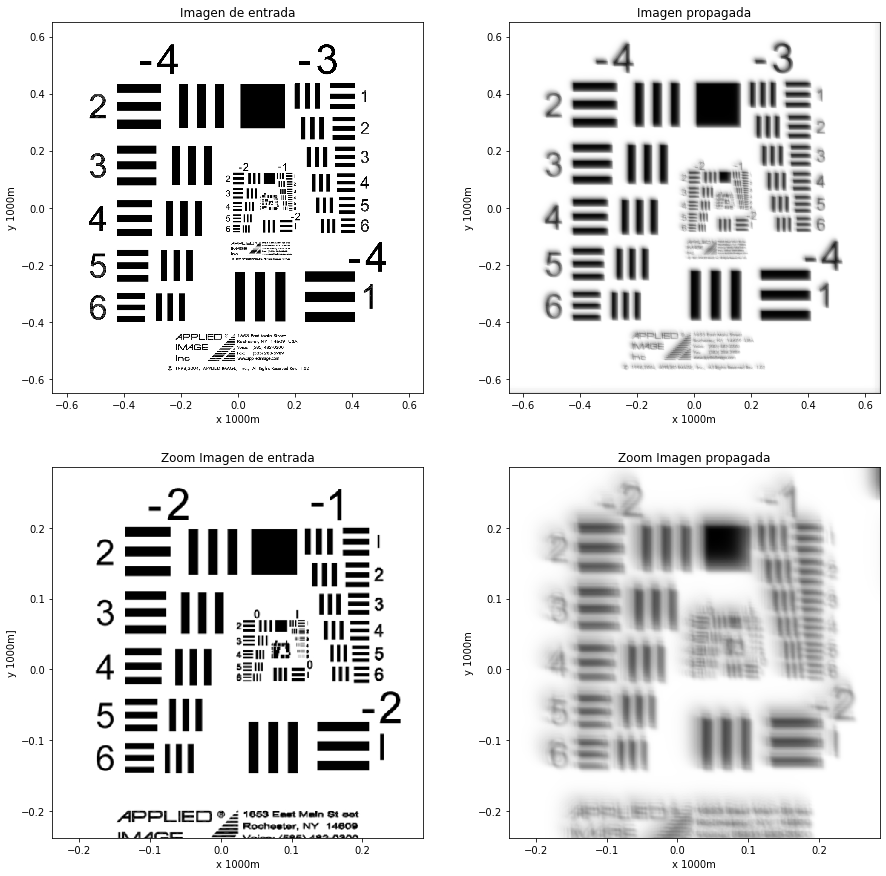

In [ ]:
fig1 = plt.figure(figsize = (15,15)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(Ig,'gray' ,interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen de entrada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')

ax1 = fig1.add_subplot(2,2,2) 
ax1.imshow(Ii,'gray' , interpolation='none',extent = [-(L/2)*1000 , (L/2)*1000, -(L/2)*1000, (L/2)*1000])
ax1.set_title('Imagen propagada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')


ax1 = fig1.add_subplot(2,2,3) 
ax1.imshow(Ig[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen de entrada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m]')


ax1 = fig1.add_subplot(2,2,4) 
ax1.imshow(Ii[750:1250,900:1400],'gray' , interpolation='none',extent = [-((750*du)/2)*1000 , ((900*du)/2)*1000, -((750*du)/2)*1000, ((900*du)/2)*1000])
ax1.set_title('Zoom Imagen propagada')
ax1.set_xlabel('x 1000m')
ax1.set_ylabel('y 1000m')